<a href="https://colab.research.google.com/github/HSAkash/Potato-Leaf-Disease-Dataset/blob/main/Generalize_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data unzip

In [ ]:
! unzip -qq "/content/drive/MyDrive/Colab Notebooks/Crops_disease/potato/Potato_data_evaluate.zip"

## Helper function

In [ ]:
!wget https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/helper_functions.py

--2022-12-16 06:32:45--  https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11995 (12K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  11.71K  --.-KB/s    in 0s      

2022-12-16 06:32:45 (71.9 MB/s) - ‘helper_functions.py.2’ saved [11995/11995]



In [ ]:
"""
Import function from helper_functions.py file
"""
from helper_functions import (
    plot_loss_curves,
    create_tensorboard_callback,
    compare_historys,
    calculate_results,
    bestWeightModelEvaluate,
    getBestWeightModel,
    saveBestWeightModel
)

## gdrive path

In [ ]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Crops_disease/potato"

## Path

In [ ]:
original_dir = "/content/Potato_data/Original"
village_dir = "/content/Potato_data/village"
plantify_dir = "/content/Potato_data/plantify"
new_dir = "/content/Potato_data/newplant"

## Load data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
CHANNEL = 3
epochs = 100

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
original_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = original_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

village_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = village_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

plantify_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = plantify_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

new_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = new_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

class_names = new_data.class_names
class_names

Found 1500 files belonging to 3 classes.
Found 2152 files belonging to 3 classes.
Found 9510 files belonging to 3 classes.
Found 7128 files belonging to 3 classes.


['Early_blight', 'Late_blight', 'healthy']

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## Potato leafe Disease

## split data

In [ ]:
DATASET_SIZE = len(original_data)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.20 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)


train_data = original_data.take(train_size)
test_data = original_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

In [ ]:
len(train_data), len(test_data), len(val_data)

(32, 4, 11)

### model for potato leaves disease

In [ ]:
cnn_model = tf.keras.models.Sequential(
    [

        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2,padding='valid'),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2,padding='valid'),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(2),
    ], name = 'cnn_model'
)

In [ ]:
potato_leaf_model = tf.keras.models.Sequential(
    [
        data_augmentation,
        cnn_model,
        tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'),
        tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')
    ], name='potato_leaf_disease'
)
potato_leaf_model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, CHANNEL))

In [ ]:
potato_leaf_model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

### Fit the model

In [ ]:
potato_leaf_checkpoint_path = f"CheckPoint/potato_leaf/cp.ckpt"
potato_leaf_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    potato_leaf_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
potato_leaf_history = potato_leaf_model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [
        potato_leaf_checkpoint_callback
    ]
)

Epoch 1/100
32/32 [==============================] - 22s 564ms/step - loss: 1.0516 - accuracy: 0.4053 - val_loss: 1.0731 - val_accuracy: 0.3592
Epoch 2/100
32/32 [==============================] - 17s 539ms/step - loss: 0.7127 - accuracy: 0.6699 - val_loss: 0.6285 - val_accuracy: 0.7040
Epoch 3/100
32/32 [==============================] - 17s 522ms/step - loss: 0.4886 - accuracy: 0.7891 - val_loss: 0.3987 - val_accuracy: 0.8362
Epoch 4/100
32/32 [==============================] - 17s 516ms/step - loss: 0.4874 - accuracy: 0.8047 - val_loss: 0.4322 - val_accuracy: 0.8448
Epoch 5/100
32/32 [==============================] - 17s 510ms/step - loss: 0.4530 - accuracy: 0.8174 - val_loss: 0.4819 - val_accuracy: 0.8046
Epoch 6/100
32/32 [==============================] - 17s 518ms/step - loss: 0.3934 - accuracy: 0.8467 - val_loss: 0.3907 - val_accuracy: 0.8592
Epoch 7/100
32/32 [==============================] - 16s 478ms/step - loss: 0.3591 - accuracy: 0.8574 - val_loss: 0.2579 - val_accuracy:

### Evaluate

In [ ]:
potato_leaf_model.evaluate(test_data)

4/4 [==============================] - 1s 45ms/step - loss: 0.0419 - accuracy: 0.9766


[0.041938211768865585, 0.9765625]

In [ ]:
potato_leaf_model.load_weights(potato_leaf_checkpoint_path)

In [ ]:
potato_leaf_model.evaluate(train_data), potato_leaf_model.evaluate(val_data), potato_leaf_model.evaluate(test_data)

4/4 [==============================] - 1s 44ms/step - loss: 0.0075 - accuracy: 1.0000


([0.006442177575081587, 0.9990234375],
 [0.009483680129051208, 1.0],
 [0.007504218257963657, 1.0])

## MOdel for villate data

### data split

In [ ]:
DATASET_SIZE = len(village_data)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.20 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)


train_data = village_data.take(train_size)
test_data = village_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

In [ ]:
len(train_data), len(test_data), len(val_data)

(47, 6, 15)

### colone model

In [ ]:
village_model = tf.keras.models.clone_model(potato_leaf_model)

In [ ]:
village_model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
village_checkpoint_path = f"CheckPoint/village/cp.ckpt"
village_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    village_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
village_history = village_model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [
        village_checkpoint_callback
    ]
)

Epoch 1/100
47/47 [==============================] - 15s 284ms/step - loss: 0.8911 - accuracy: 0.4914 - val_loss: 0.8445 - val_accuracy: 0.6382
Epoch 2/100
47/47 [==============================] - 14s 305ms/step - loss: 0.7481 - accuracy: 0.6536 - val_loss: 0.9307 - val_accuracy: 0.5351
Epoch 3/100
47/47 [==============================] - 12s 252ms/step - loss: 0.6544 - accuracy: 0.7194 - val_loss: 0.5105 - val_accuracy: 0.8114
Epoch 4/100
47/47 [==============================] - 15s 319ms/step - loss: 0.5339 - accuracy: 0.7746 - val_loss: 0.3923 - val_accuracy: 0.8553
Epoch 5/100
47/47 [==============================] - 13s 276ms/step - loss: 0.4089 - accuracy: 0.8424 - val_loss: 0.3739 - val_accuracy: 0.8311
Epoch 6/100
47/47 [==============================] - 12s 253ms/step - loss: 0.4417 - accuracy: 0.8085 - val_loss: 0.3355 - val_accuracy: 0.8794
Epoch 7/100
47/47 [==============================] - 14s 287ms/step - loss: 0.3715 - accuracy: 0.8444 - val_loss: 0.3805 - val_accuracy:

### Evaluate

In [ ]:
village_model.evaluate(test_data)

6/6 [==============================] - 2s 49ms/step - loss: 0.0672 - accuracy: 0.9740


[0.06718045473098755, 0.9739583134651184]

In [ ]:
village_model.load_weights(village_checkpoint_path)

In [ ]:
village_model.evaluate(train_data), village_model.evaluate(val_data),village_model.evaluate(test_data)

6/6 [==============================] - 2s 43ms/step - loss: 0.0101 - accuracy: 0.9948


([0.0037075900472700596, 0.9993351101875305],
 [0.006184410769492388, 0.9978070259094238],
 [0.010114330798387527, 0.9947916865348816])

## plantify_data model

In [ ]:
DATASET_SIZE = len(plantify_data)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.20 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)


train_data = plantify_data.take(train_size)
test_data = plantify_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

In [ ]:
len(train_data), len(test_data), len(val_data)

(208, 29, 61)

In [ ]:
plantify_model = tf.keras.models.clone_model(potato_leaf_model)


In [ ]:
plantify_model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [ ]:
plantify_checkpoint_path = f"CheckPoint/plantify/cp.ckpt"
plantify_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    plantify_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
plantify_history = plantify_model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [
        plantify_checkpoint_callback
    ]
)

Epoch 1/100
208/208 [==============================] - 43s 201ms/step - loss: 0.7701 - accuracy: 0.6203 - val_loss: 0.3131 - val_accuracy: 0.8858
Epoch 2/100
208/208 [==============================] - 43s 203ms/step - loss: 0.3162 - accuracy: 0.8827 - val_loss: 0.5192 - val_accuracy: 0.8063
Epoch 3/100
208/208 [==============================] - 43s 205ms/step - loss: 0.2157 - accuracy: 0.9280 - val_loss: 0.1703 - val_accuracy: 0.9387
Epoch 4/100
208/208 [==============================] - 40s 188ms/step - loss: 0.2219 - accuracy: 0.9232 - val_loss: 0.1943 - val_accuracy: 0.9273
Epoch 5/100
208/208 [==============================] - 40s 189ms/step - loss: 0.1558 - accuracy: 0.9488 - val_loss: 0.0893 - val_accuracy: 0.9699
Epoch 6/100
208/208 [==============================] - 38s 184ms/step - loss: 0.1264 - accuracy: 0.9608 - val_loss: 0.1091 - val_accuracy: 0.9621
Epoch 7/100
208/208 [==============================] - 41s 194ms/step - loss: 0.1398 - accuracy: 0.9543 - val_loss: 0.1275 -

In [ ]:
plantify_model.evaluate(test_data)

22/22 [==============================] - 7s 43ms/step - loss: 0.0052 - accuracy: 1.0000


[0.00520824221894145, 1.0]

In [ ]:
plantify_model.load_weights(plantify_checkpoint_path)

In [ ]:
plantify_model.evaluate(train_data),
plantify_model.evaluate(val_data),
plantify_model.evaluate(test_data)

22/22 [==============================] - 6s 41ms/step - loss: 0.0062 - accuracy: 1.0000


[0.006248200312256813, 1.0]

## new_data

In [ ]:
DATASET_SIZE = len(new_data)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.20 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)


train_data = new_data.take(train_size)
test_data = new_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)


In [ ]:
len(train_data), len(test_data), len(val_data)

(156, 22, 45)

In [ ]:
new_data_model = tf.keras.models.clone_model(potato_leaf_model)

In [ ]:
new_data_model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
new_data_checkpoint_path = f"CheckPoint/new_data/cp.ckpt"
new_data_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    new_data_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
new_data_history = new_data_model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [
        new_data_checkpoint_callback
    ]
)

Epoch 1/100
156/156 [==============================] - 25s 149ms/step - loss: 0.8815 - accuracy: 0.5641 - val_loss: 0.6258 - val_accuracy: 0.7570
Epoch 2/100
156/156 [==============================] - 21s 132ms/step - loss: 0.3810 - accuracy: 0.8504 - val_loss: 1.7881 - val_accuracy: 0.5656
Epoch 3/100
156/156 [==============================] - 20s 129ms/step - loss: 0.2192 - accuracy: 0.9209 - val_loss: 0.9534 - val_accuracy: 0.6425
Epoch 4/100
156/156 [==============================] - 20s 128ms/step - loss: 0.1913 - accuracy: 0.9289 - val_loss: 0.7958 - val_accuracy: 0.7081
Epoch 5/100
156/156 [==============================] - 20s 128ms/step - loss: 0.1276 - accuracy: 0.9563 - val_loss: 0.2792 - val_accuracy: 0.8855
Epoch 6/100
156/156 [==============================] - 20s 129ms/step - loss: 0.1062 - accuracy: 0.9639 - val_loss: 0.1710 - val_accuracy: 0.9295
Epoch 7/100
156/156 [==============================] - 20s 128ms/step - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.7154 -

In [ ]:
new_data_model.evaluate(test_data)

22/22 [==============================] - 6s 44ms/step - loss: 0.0022 - accuracy: 1.0000


[0.0021892981603741646, 1.0]

In [ ]:
new_data_model.load_weights(new_data_checkpoint_path)

In [ ]:
new_data_model.evaluate(train_data), new_data_model.evaluate(val_data),new_data_model.evaluate(test_data)

22/22 [==============================] - 6s 43ms/step - loss: 0.0034 - accuracy: 1.0000


([0.00733145559206605, 0.9983974099159241],
 [0.006253167055547237, 0.9993016719818115],
 [0.003358091227710247, 1.0])

In [ ]:
history_dict = {
    'potato_leaf_diseas' : potato_leaf_history,
    "village": village_history,
    "plantify": plantify_history,
    "new_data": new_data_history
}

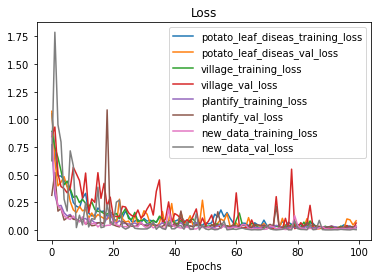

In [ ]:
x = range(epochs)
for history in history_dict:
    loss = history_dict[history].history['loss']
    val_loss = history_dict[history].history['val_loss']
    plt.plot(x, loss, label=f'{history}_training_loss')
    plt.plot(x, val_loss, label=f'{history}_val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

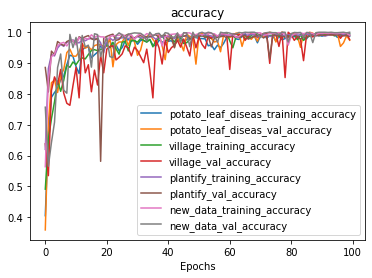

In [ ]:
x = range(epochs)
for history in history_dict:
    accuracy = history_dict[history].history['accuracy']
    val_accuracy = history_dict[history].history['val_accuracy']
    plt.plot(x, accuracy, label=f'{history}_training_accuracy')
    plt.plot(x, val_accuracy, label=f'{history}_val_accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
# Potato Leaf Disease Dataset, New Plant Diseases Dataset, PlantifyDr Dataset

In [ ]:
history_dict = {
    'Potato Leaf Disease' : potato_leaf_history,
    "Bangladeshi": village_history,
    "PlantifyDr": plantify_history,
    "New Plant": new_data_history
}

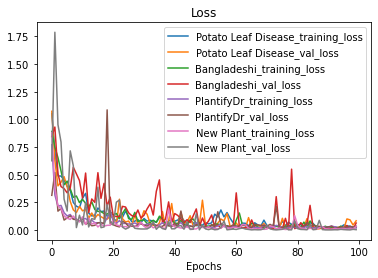

In [ ]:
x = range(epochs)
for history in history_dict:
    loss = history_dict[history].history['loss']
    val_loss = history_dict[history].history['val_loss']
    plt.plot(x, loss, label=f'{history}_training_loss')
    plt.plot(x, val_loss, label=f'{history}_val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

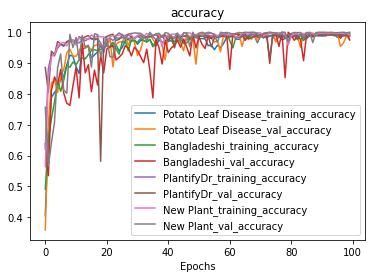

In [ ]:
x = range(epochs)
for history in history_dict:
    accuracy = history_dict[history].history['accuracy']
    val_accuracy = history_dict[history].history['val_accuracy']
    plt.plot(x, accuracy, label=f'{history}_training_accuracy')
    plt.plot(x, val_accuracy, label=f'{history}_val_accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.legend()

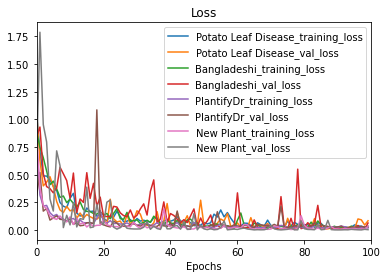

In [ ]:
x = range(epochs)
for history in history_dict:
    loss = history_dict[history].history['loss']
    val_loss = history_dict[history].history['val_loss']
    plt.plot(x, loss, label=f'{history}_training_loss')
    plt.plot(x, val_loss, label=f'{history}_val_loss')
plt.xlim(0, epochs)
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

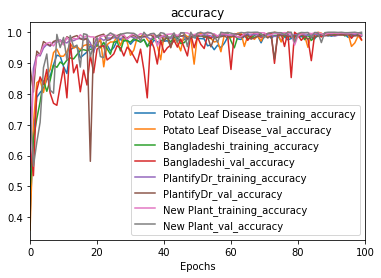

In [ ]:
x = range(epochs)
for history in history_dict:
    accuracy = history_dict[history].history['accuracy']
    val_accuracy = history_dict[history].history['val_accuracy']
    plt.plot(x, accuracy, label=f'{history}_training_accuracy')
    plt.plot(x, val_accuracy, label=f'{history}_val_accuracy')
plt.xlim(0, epochs)
plt.title('accuracy')
plt.xlabel('Epochs')
plt.legend()

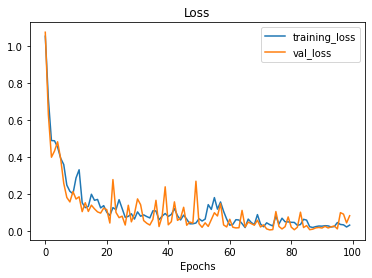

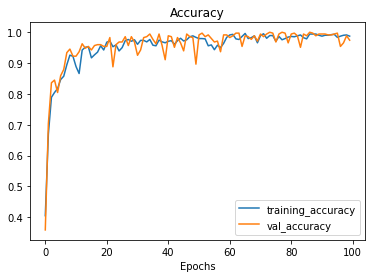

In [ ]:
plot_loss_curves(potato_leaf_history)

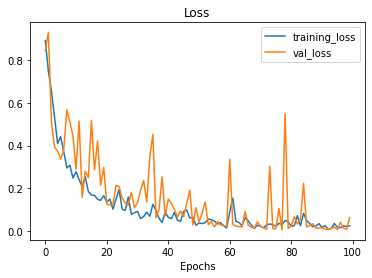

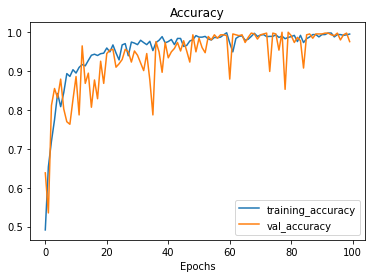

In [ ]:
plot_loss_curves(village_history)

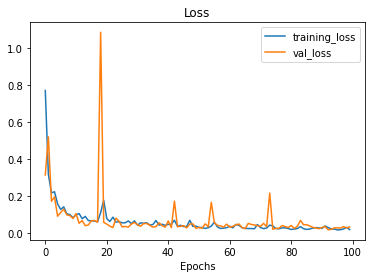

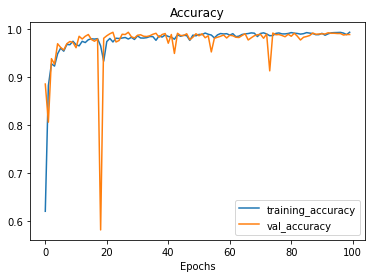

In [ ]:
plot_loss_curves(plantify_history)

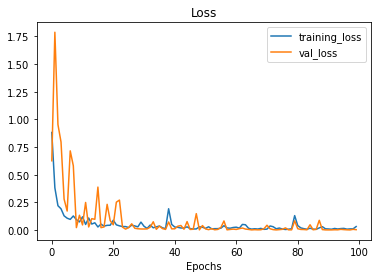

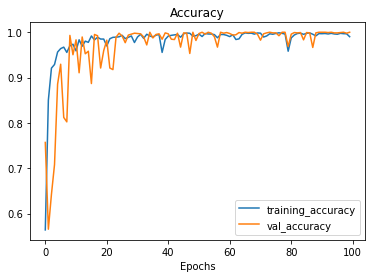

In [ ]:
plot_loss_curves(new_data_history)